In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import csv
import json

# Underground Alarm

First of all, we analyze the metrics of the disruptive scenario and compute responsiveness and fidelity.

In [2]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
underground_file = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups/21111008_21111014/sf_final_metrics.csv')
df_under = pd.read_csv(underground_file)
df_under.columns

Index(['timestamp', 'passengers_new', 'passengers_departures',
       'passengers_arrivals', 'passengers_unassigned', 'passengers_assigned',
       'passengers_accept', 'passengers_reject', 'passengers_cancel',
       'drivers_shift_duration_avg', 'drivers_total_length_avg',
       'drivers_idle_duration_avg', 'drivers_occupied_distance_avg',
       'drivers_occupied_duration_avg', 'drivers_passengers_served',
       'drivers_idle', 'drivers_pickup', 'drivers_busy', 'drivers_accept',
       'drivers_reject', 'drivers_removed', 'rides_in_progress',
       'rides_waiting_duration_avg', 'rides_duration_avg', 'rides_length_avg',
       'rides_duration_expected_avg', 'rides_length_expected_avg',
       'rides_dispatched', 'rides_partial_acceptances', 'rides_not_served',
       'rides_offers_generated', 'rides_offers_radius_avg',
       'rides_offers_price_avg', 'rides_offers_surge_avg',
       'traffic_in_progress', 'traffic_departures', 'traffic_arrivals',
       'traffic_duration_avg', 't

In [3]:
# Surge multiplier columns that shouldn't be smoothed but padded
surge_columns = [
    "rides_offers_surge_avg",
    "rides_offers_surge_lyft_avg",
    "rides_offers_surge_uber_avg"
]
# Agents columns that should be padded with forward-fill every 60 seconds before smoothing
agent_columns = [
    "passengers_unassigned",
    "passengers_assigned",
    "passengers_accept",
    "passengers_reject",
    "passengers_cancel",
    "drivers_idle",
    "drivers_pickup",
    "drivers_busy",
    "drivers_accept",
    "drivers_reject",
    "drivers_removed",
    "rides_duration_expected_avg",
    "rides_length_expected_avg",
    "rides_offers_radius_avg",
    "rides_offers_price_avg",
    "rides_dispatched",
    "rides_in_progress",
    "rides_offers_generated",
    "rides_partial_acceptances"
]

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df_under[col] = df_under[col].replace(0, np.nan)
    df_under[col] = df_under[col].fillna('ffill')

# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df_under), 60):
        val = df_under.at[i, col]
        df_under.loc[i:i+59, col] = val

# Apply rolling mean to all other columns
rolling_cols = [col for col in df_under.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df_under[col] = df_under[col].rolling(window=300).mean().dropna()

# Plot each column (excluding timestamp)
'''
for column in df_under.columns:
    if column == "timestamp":
        continue
    plt.figure()
    plt.plot(df_under["timestamp"], df_under[column], label=column)
    plt.title(f"Processed: {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()
'''


'\nfor column in df_under.columns:\n    if column == "timestamp":\n        continue\n    plt.figure()\n    plt.plot(df_under["timestamp"], df_under[column], label=column)\n    plt.title(f"Processed: {column}")\n    plt.xlabel("Timestamp")\n    plt.ylabel(column)\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n'

## Compare with Normal

ValueError: could not convert string to float: 'ffill'

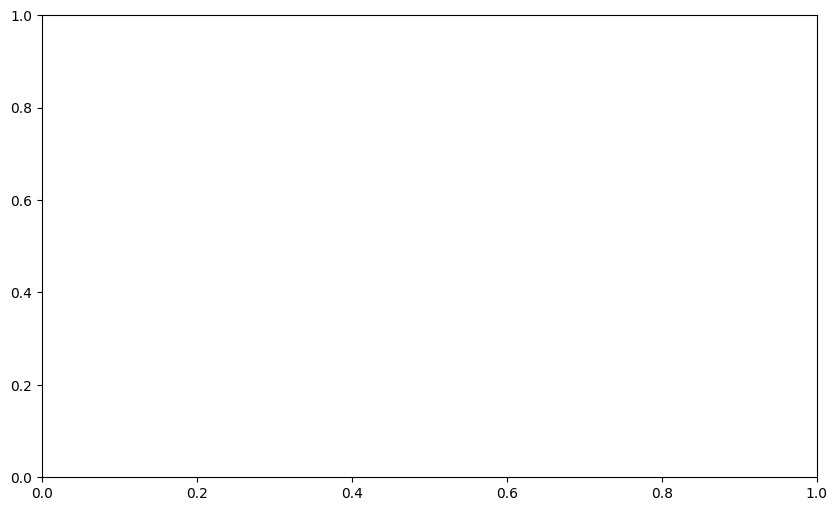

In [4]:
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
normal_file = os.path.join(projectPath, 'sumoenv/scenarios/normal/social_groups_2/21111008_21111014/sf_final_metrics.csv')
df = pd.read_csv(normal_file)

# Surge multiplier columns that shouldn't be smoothed but padded
surge_columns = [
    "rides_offers_surge_avg",
    "rides_offers_surge_lyft_avg",
    "rides_offers_surge_uber_avg"
]
# Agents columns that should be padded with forward-fill every 60 seconds before smoothing
agent_columns = [
    "passengers_unassigned",
    "passengers_assigned",
    "passengers_accept",
    "passengers_reject",
    "passengers_cancel",
    "drivers_idle",
    "drivers_pickup",
    "drivers_busy",
    "drivers_accept",
    "drivers_reject",
    "drivers_removed",
    "rides_duration_expected_avg",
    "rides_length_expected_avg",
    "rides_offers_radius_avg",
    "rides_offers_price_avg",
    "rides_dispatched",
    "rides_in_progress",
    "rides_offers_generated",
    "rides_partial_acceptances"
]

# Process the surge_columns: pad with forward-fill
for col in surge_columns:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna('ffill')

# Process the agent_columns: pad with forward-fill
for col in agent_columns:
    for i in range(0, len(df), 60):
        val = df.at[i, col]
        df.loc[i:i+59, col] = val

# Apply rolling mean to all other columns
rolling_cols = [col for col in df.columns if col not in surge_columns + ["timestamp"]]
for col in rolling_cols:
    df[col] = df[col].rolling(window=300).mean().dropna()

df = df[5400:-3600]
df_under = df_under[5400:-3600]

plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["rides_offers_surge_avg"], label="Normal")
plt.plot(df_under["rides_offers_surge_avg"], label="Underground", linestyle='--')
plt.title(f"Avg Surge Multiplier Comparison", fontsize=18)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Avg Surge Multiplier Value", fontsize=14)
plt.ylim(0, 3.5)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("results/avg_surge_multiplier_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

## Responsiveness

In [ ]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups')

records = []
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'simulation_summary.csv')
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            first_row = df.iloc[0]
            elapsed_sec = first_row['total_elapsed_seconds']
            sumo_sec = first_row['sumo_time']
            agents_sec = first_row['agents_time']
            records.append({
                'mode': 'social_groups',
                'date': date,
                'elapsed_seconds': elapsed_sec,
                'elapsed_minutes': round(elapsed_sec / 60, 2),
                'sumo_time': sumo_sec,
                'sumo_minutes': round(sumo_sec / 60, 2),
                'agents_time': agents_sec,
                'agents_minutes': round(agents_sec / 60, 2)
            })
# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_underground.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Responsiveness summary saved to: {output_file}")

Efficiency summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/efficiency_underground.csv


In [ ]:
# Compare responsiveness ratio of underground and normal scenarios
df_under = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_underground.csv'))
df_normal = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
df_under_dates = df_under['date'].unique()
df_normal = df_normal[df_normal['mode'] == 'social_groups_avg']
df_normal = df_normal[df_normal['date'].isin(df_under_dates)]
total_under = df_under['elapsed_seconds'].sum()
total_normal = df_normal['elapsed_seconds'].sum()
ratio = ((total_under - total_normal) / total_normal) * 100
print(f"Responsiveness ratio (underground/normal): {ratio:.2f}%")

Efficiency ratio (underground/normal): 20.51%


## Fidelity

In [ ]:
def get_pickups_dropoffs(
        sf_rides_stats_path,
        start_date_str,
        start_time_str,
        end_date_str,
        end_time_str,
        tazs_involved = None
    ):
    start_date = datetime.strptime(start_date_str, "%y%m%d").date()
    end_date = datetime.strptime(end_date_str, "%y%m%d").date()
    num_days = (end_date - start_date).days + 1

    # Parse start and end hours
    start_hour = int(datetime.strptime(start_time_str, "%H").hour)
    end_hour = int(datetime.strptime(end_time_str, "%H").hour)

    # Map dataset hours (3–26) to standard 0–23 format
    dataset_hour_map = {h: h % 24 for h in range(3, 27)}

    # Read the CSV file    
    all_rows = []
    with open(sf_rides_stats_path, mode='r') as file:
        reader = csv.DictReader(file, delimiter=',')
        for row in reader:
            row['taz'] = int(row['taz'])
            row['day_of_week'] = int(row['day_of_week'])
            row['hour'] = int(row['hour'])
            row['pickups'] = round(float(row['pickups']))
            row['dropoffs'] = round(float(row['dropoffs']))
            all_rows.append(row)

    # Index by (day_of_week, hour, taz)
    data_by_key = {}
    for row in all_rows:
        key = (row['day_of_week'], row['hour'], row['taz'])
        data_by_key[key] = {'pickups': row['pickups'], 'dropoffs': row['dropoffs']}

    zone_data = {}
    # For each simulation day, determine hours to include from that day
    for sim_day_index in range(num_days):
        sim_date = start_date + timedelta(days=sim_day_index)
        sim_day_of_week = sim_date.weekday()
        if num_days == 1:
            selected_std_hours = list(range(start_hour, end_hour))
        else:
            if sim_day_index == 0:
                selected_std_hours = list(range(start_hour, 24))
            elif sim_day_index == num_days - 1:
                selected_std_hours = list(range(0, end_hour))
            else:
                selected_std_hours = list(range(0, 24))
        selected_dataset_hours = {h: std for h, std in dataset_hour_map.items() if std in selected_std_hours}
        # Filter rows for this day and hour
        for row in all_rows:
            taz = row['taz']
            hour = row['hour']
            day = row['day_of_week']
            if day == sim_day_of_week and hour in selected_dataset_hours:
                std_hour = selected_dataset_hours[hour]
                if taz not in zone_data:
                    zone_data[taz] = {}
                zone_data[taz][std_hour] = {
                    'pickups': row['pickups'],
                    'dropoffs': row['dropoffs']
                }
    
    # If tazs_involved is provided, adjust pickups and dropoffs based on "underground" disruptive scenario
    if tazs_involved:
        for taz in zone_data:
            if taz in tazs_involved:
                for hour in zone_data[taz]:
                    if hour == 23 or hour == 11:
                        zone_data[taz][hour]['pickups'] += round((zone_data[taz][hour]['pickups'] * 2) * 0.7)
                        zone_data[taz][hour]['dropoffs'] += round((zone_data[taz][hour]['dropoffs'] * 2) * 0.7)

    # Compute pickups and dropoffs across all zones and selected hours
    total_pickups = sum(hour_data['pickups'] for zone in zone_data.values() for hour_data in zone.values())
    total_dropoffs = sum(hour_data['dropoffs'] for zone in zone_data.values() for hour_data in zone.values())

    return total_pickups, total_dropoffs


def percent_error(true_val, estimated_val):
    return 100 * abs(true_val - estimated_val) / true_val if true_val != 0 else float('nan')

In [ ]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/underground_alarm/social_groups')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

# Initialize records and TAZs involved
records = []
tazs_involved = None
with open(os.path.join(projectPath, "config/zip_zones_config.json"), "r") as f:
    zip_zones = json.load(f)
    tazs_involved = []
    with open(os.path.join(projectPath, "data/sf_zones/sf_sfcta_stanford_mapping.json"), "r") as f:
        sfcta_mapping = json.load(f)
    for taz in zip_zones["downtown"]:
        if taz in sfcta_mapping:
            tazs_involved.extend(sfcta_mapping[taz])

# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
    # Get real traffic data
    traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
    try:
        traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
        # Here we read the traffic data related to the disruptive scenario
        od_df = pd.read_csv(os.path.join(date_path, f"sf_traffic_od_{date}.csv"), sep=';')
    except:
        continue
    
    # Filter the traffic data by hours and TAZs involved
    if tazs_involved:
        od_df = od_df[od_df['origin_taz_id'].isin(tazs_involved)]
        od_df_filtered_taz = od_df.copy()
        od_df_filtered_taz['origin_starting_time'] = pd.to_datetime(od_df_filtered_taz['origin_starting_time'])
        time_ranges = [
        (pd.to_datetime('11:00:00').time(), pd.to_datetime('11:40:00').time()),
        (pd.to_datetime('23:00:00').time(), pd.to_datetime('23:40:00').time())
        ]
        od_df_filtered_taz_time = od_df_filtered_taz[
            od_df_filtered_taz['origin_starting_time'].dt.time.between(*time_ranges[0]) |
            od_df_filtered_taz['origin_starting_time'].dt.time.between(*time_ranges[1])
        ]
        # Consider +50% traffic
        base_count = len(od_df_filtered_taz_time) * 0.64
        added_count = int(base_count * 0.5)
        new_count = base_count + added_count
    else:
        new_count = 0
    traffic = (len(traffic_df)-1) if traffic_file else 0
    # Scale traffic: 36% of traffic is TNC
    traffic = traffic + new_count
    traffic_scaled = int(traffic * 0.64)

    # Get pickups and dropoffs data
    start_str, end_str = date.split('_')
    pickups, dropoffs = get_pickups_dropoffs(
        os.path.join(sfcta_dir, "trip_stats_taz.csv"),
        start_str[:6],
        start_str[6:],
        end_str[:6],
        end_str[6:],
        tazs_involved
    )

    # Recotrd the results
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            traffic_count = sum(df['traffic_departures'])
            pickup_count = sum(df['passengers_departures'])
            dropoff_count = sum(df['passengers_arrivals'])
            canceled_count = sum(df['passengers_cancel'])
            traffic_error = percent_error(traffic_scaled, traffic_count)
            pickup_error = percent_error(pickups, pickup_count)
            dropoff_error = percent_error(dropoffs, dropoff_count)
            pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
            dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
            records.append({
                'mode': 'social_groups',
                'date': date,
                'traffic_input': traffic_scaled,
                'pickup_input': pickups,
                'dropoff_input': dropoffs,
                'traffic_output': traffic_count,
                'pickup_output': pickup_count,
                'dropoff_output': dropoff_count,
                'traffic_error': round(traffic_error, 2),
                'pickup_error': round(pickup_error, 2),
                'dropoff_error': round(dropoff_error, 2),
                'canceled_rides': canceled_count,
                'pickup_scaled_error': round(pickup_scaled_error, 2),
                'dropoff_scaled_error': round(dropoff_scaled_error, 2)
            })

# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/fidelity_underground.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Fidelity summary saved to: {output_file}")

Fidelity summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/fidelity_underground.csv


In [ ]:
# Compare fidelity of underground and normal scenarios
df_under = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_underground.csv'))
df_normal = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_normal.csv'))
df_under_dates = df_under['date'].unique()
df_normal = df_normal[df_normal['mode'] == 'social_groups_avg']
df_normal = df_normal[df_normal['date'].isin(df_under_dates)]
under_traffic_error = df_under['traffic_error'].mean()
normal_traffic_error = df_normal['traffic_error'].mean()
under_pickup_error = 100 - df_under['pickup_scaled_error'].mean()
normal_pickup_error = 100 - df_normal['pickup_scaled_error'].mean()
under_dropoff_error = 100 - df_under['dropoff_scaled_error'].mean()
normal_dropoff_error = 100 - df_normal['dropoff_scaled_error'].mean()
under_rides_canceled = df_under['canceled_rides'].mean()
normal_rides_canceled = df_normal['canceled_rides'].mean()
traffic_ratio = ((under_traffic_error - normal_traffic_error) / normal_traffic_error) * 100
pickup_ratio = ((under_pickup_error - normal_pickup_error) / normal_pickup_error) * 100
dropoff_ratio = ((under_dropoff_error - normal_dropoff_error) / normal_dropoff_error) * 100
canceled_ratio = ((under_rides_canceled - normal_rides_canceled) / normal_rides_canceled) * 100
print(f"Traffic fidelity ratio (underground/normal): {traffic_ratio:.2f}%")
print(f"Pickup fidelity ratio (underground/normal): {pickup_ratio:.2f}%")
print(f"Dropoff fidelity ratio (underground/normal): {dropoff_ratio:.2f}%")
print(f"Canceled rides ratio (underground/normal): {canceled_ratio:.2f}%")

Traffic fidelity ratio (underground/normal): 2.81%
Pickup fidelity ratio (underground/normal): -0.26%
Dropoff fidelity ratio (underground/normal): -0.19%
Canceled rides ratio (underground/normal): 141.84%


# Flat Provider

## Responsiveness

In [ ]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal_new_prov/social_groups')

records = []
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'simulation_summary.csv')
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            first_row = df.iloc[0]
            elapsed_sec = first_row['total_elapsed_seconds']
            sumo_sec = first_row['sumo_time']
            agents_sec = first_row['agents_time']
            records.append({
                'mode': 'social_groups',
                'date': date,
                'elapsed_seconds': elapsed_sec,
                'elapsed_minutes': round(elapsed_sec / 60, 2),
                'sumo_time': sumo_sec,
                'sumo_minutes': round(sumo_sec / 60, 2),
                'agents_time': agents_sec,
                'agents_minutes': round(agents_sec / 60, 2)
            })
# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_normal_new_prov.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Responsiveness summary saved to: {output_file}")

Efficiency summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/efficiency_normal_new_prov.csv


In [ ]:
# Compare responsiveness ratio of new provider and standard config
df_flat = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal_new_prov.csv'))
df_normal = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
df_normal = df_normal[df_normal['mode'] == 'social_groups_avg']
total_flat = df_flat['elapsed_seconds'].sum()
total_normal = df_normal['elapsed_seconds'].sum()
print(f"Total elapsed seconds (flat): {total_flat}")
print(f"Total elapsed seconds (normal): {total_normal}")
ratio = ((total_flat - total_normal) / total_flat) * 100
print(f"Responsiveness ratio (flat/normal): {ratio:.2f}%")

Total elapsed seconds (flat): 256443.28000000003
Total elapsed seconds (normal): 127460.29000000001
Efficiency ratio (flat/normal): 50.30%


## Fidelity

In [ ]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
mode_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal_new_prov/social_groups')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

records = []
# Traverse each folder inside the mode
for date in os.listdir(mode_dir):
    date_path = os.path.join(mode_dir, date)
    if not os.path.isdir(date_path):
        continue
    summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
    # Get real traffic and pickup/dropoff data
    traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
    try:
        traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
    except:
        continue
    traffic = (len(traffic_df)-1) if traffic_file else 0
    # Scale traffic: 36% of traffic is TNC
    traffic_scaled = int(traffic * 0.64)
    start_str, end_str = date.split('_')
    pickups, dropoffs = get_pickups_dropoffs(
        os.path.join(sfcta_dir, "trip_stats_taz.csv"),
        start_str[:6],
        start_str[6:],
        end_str[:6],
        end_str[6:]
    )
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if not df.empty:
            traffic_count = sum(df['traffic_departures'])
            pickup_count = sum(df['passengers_departures'])
            dropoff_count = sum(df['passengers_arrivals'])
            canceled_count = sum(df['passengers_cancel']) + sum(df['rides_not_served'])
            traffic_error = percent_error(traffic_scaled, traffic_count)
            pickup_error = percent_error(pickups, pickup_count)
            dropoff_error = percent_error(dropoffs, dropoff_count)
            pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
            dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
            records.append({
                'mode': 'social_groups',
                'date': date,
                'traffic_input': traffic_scaled,
                'pickup_input': pickups,
                'dropoff_input': dropoffs,
                'traffic_output': traffic_count,
                'pickup_output': pickup_count,
                'dropoff_output': dropoff_count,
                'traffic_error': round(traffic_error, 2),
                'pickup_error': round(pickup_error, 2),
                'dropoff_error': round(dropoff_error, 2),
                'canceled_rides': canceled_count,
                'pickup_scaled_error': round(pickup_scaled_error, 2),
                'dropoff_scaled_error': round(dropoff_scaled_error, 2)
            })

# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/fidelity_normal_new_prov.csv')
summary_df = summary_df.sort_values(by=['date'])
summary_df.to_csv(output_file, index=False)

print(f"Fidelity summary saved to: {output_file}")

Fidelity summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/fidelity_normal_new_prov.csv


In [ ]:
# Compare fidelity of new provider and standard config
df_flat = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_normal_new_prov.csv'))
df_normal = pd.read_csv(os.path.join(projectPath, 'experiments/results/fidelity_normal.csv'))
df_normal = df_normal[df_normal['mode'] == 'social_groups_avg']
flat_traffic_error = df_flat['traffic_error'].mean()
normal_traffic_error = df_normal['traffic_error'].mean()
flat_pickup_error = 100 - df_flat['pickup_scaled_error'].mean()
normal_pickup_error = 100 - df_normal['pickup_scaled_error'].mean()
flat_dropoff_error = 100 - df_flat['dropoff_scaled_error'].mean()
normal_dropoff_error = 100 - df_normal['dropoff_scaled_error'].mean()
flat_rides_canceled = df_flat['canceled_rides'].mean()
normal_rides_canceled = df_normal['canceled_rides'].mean()
traffic_ratio = ((flat_traffic_error - normal_traffic_error) / normal_traffic_error) * 100
pickup_ratio = ((flat_pickup_error - normal_pickup_error) / normal_pickup_error) * 100
dropoff_ratio = ((flat_dropoff_error - normal_dropoff_error) / normal_dropoff_error) * 100
canceled_ratio = ((flat_rides_canceled - normal_rides_canceled) / normal_rides_canceled) * 100
print(f"Traffic fidelity ratio (flat/normal): {traffic_ratio:.2f}%")
print(f"Pickup fidelity ratio (flat/normal): {pickup_ratio:.2f}%")
print(f"Dropoff fidelity ratio (flat/normal): {dropoff_ratio:.2f}%")
print(f"Canceled rides ratio (flat/normal): {canceled_ratio:.2f}%")

6451.708333333333
3404.722222222222
Traffic fidelity ratio (flat/normal): -3.76%
Pickup fidelity ratio (flat/normal): 0.07%
Dropoff fidelity ratio (flat/normal): 0.05%
Canceled rides ratio (flat/normal): 89.49%
